# Marginal Gaussian Process

### The Model

A Marginal Gaussian process jointly represents the data as a large probability distribution. This distribution, as we will see, turns out to a normal distribution in classical Bayesian approaches. Suppose we have some data $X, y$ using which we want to predict the distribution over some $y_*$ given new data $X_*$. We write this as:

$$P(y_* \mid X, y, X_*)$$

This distribution is known as the ***conditional*** distribution.

We can construct this joint density through the use of the following decomposition:

$$P(y_* \mid X, y, X_*) = \int{ P(y_* \mid X_*, \theta) P(\theta \mid X, y) }$$

where we represent all the parameters by $\theta$ and $P(\theta \mid X, y)$ is the posterior density given data and $P(y_* \mid X_*, \theta)$ is known as the ***marginal likelihood*** of the individual test point given the parameters.

The marginal likelihood of the model is assumed to be a gaussian with parameters:

$$P(y \mid X, \theta) = \mathcal{N}(m(X), K(X, X) + \delta(\epsilon))$$

where $m(\cdot)$ is the ***mean*** function and $K(\cdot)$ is the ***kernel*** function. The mean function evaluates a mean vector. The kernel function takes some parameters $\theta$, evaluates the covariance between every pair of data points, and outputs a covariance matrix. The $\delta(\cdot)$ is the kronecker delta function and $\epsilon$ is a small noise. The delta function adds a small noise corruption and is equivalent to adding noise distrbuted as $\mathcal{N}(0, \epsilon\mathrm{I})$.

This mean vector and the covariance matrix is then input to the multivariate normal distribution. This choice of using a normal distribution makes the integral in the conditional distribution analytical, hence, making it easy to infer a distrution over the test data for prediction and generation.

### Performing Inference

The conditional distribution can also be shown to be a normal distrbution with parameters:

$$P(y_* \mid X, y, X_*) = \mathcal{N}(\mu_{y_* \mid D}, \Sigma_{y_* \mid D})$$

where

$$
\begin{align*}
\mu_{y_* \mid D}    &= K_*^T \left( K + \epsilon\mathrm{I} \right)^{-1} y \\
\Sigma_{y_* \mid D} &= K_{**} - K_*^T \left( K + \epsilon\mathrm{I} \right)^{-1} K_* \\
K_*                 &= K(X, X_*) \\
K_{**}              &= K(X_*, X_*) \\
K                   &= K(X, X)
\end{align*}
$$

This distribution can be used to make predictions over the test data or generate predictive samples.

### References

- http://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote15.html
- http://inverseprobability.com/talks/notes/gaussian-processes.html

# MarginalGP Model

`MarginalGP` model is the implementation of the Marginal GP model in PyMC4. It contains `marginal_likelihood` and `conditional` method that does exactly as described in the previous section. Moreover, it also has methods `predict` and `predictt` to sample from the conditional distribution and to get point estimate ($\mu_{y_* \mid D}$) of the conditional distribution respectively.

Let's see each method in detail in the following sections:

### `marginal_likelihood` method

First, we need to instantiate the model using a kernel function and (optionally) a mean function.

```python
from pymc4.gp import MarginalGP
from pymc4.gp.cov import ExpQuad

# Let's first instantiate a kernel
K = ExpQuad(length_scale = 1.)

# Now, we can instantiata the model
gp = MarginalGP(cov_fn = K)
```

Now, To get the ``marginal_likelihood`` of the MarginalGP over some data ``X`` (of shape `(n_samples, n_features)`) with labels ``y`` (of shape `(n_samples, )`), use:

```python
noise = 1e-2
y_ = gp.marginal_likelihood("y_", X, y, noise=noise)
```

You can also pass a covariance object as noise to the `marginal_likelihood`
method:
        
```python
# kronecker delta function with epsilon 1e-2
noise = WhiteNoise(1e-2)
y_ = gp.marginal_likelihood("y_", X, y, noise=noise)
```

If ``y`` is not the observed data, pass ``is_observed=False`` in the
        marginal likelihood method:

```python
y_ = gp.marginal_likelihood("y_", X, y, noise=noise, is_observed=False)
```

By default, some ``jitter`` is added to ensure Cholesky Decomposition passes.
        This behavior can be turned off by passing ``jitter=0`` in the marginal
        likelihood method:

```python
y_ = gp.marginal_likelihood("y_", X, y, noise=noise, jitter=0)
```

As ``noise`` behaves exactly as ``jitter``, it is recommended to set ``jitter=False``
        to avoid adding extra noise.

### `conditional` method

You can use conditional method to get the conditional distribution
        over the new data points. This distribution can be used to predict
        over the new data points:
        
```python
y_pred = gp.conditional("y_pred", Xnew, given={"X": X, "y": y, "noise": noise})
```

where `Xnew` are the test points (new data points) and `y_pred` is a multivariate normal distribution. `given` dictionary is optional when `marginal_likelihood` method has been called before.

```python
y_ = gp.marginal_likelihood("y_", X, y, noise=noise)
y_pred = gp.conditional("y_pred", Xnew) # no need to pass given
```

To add noise in the conditional distribution, use:

```python
y_pred = gp.conditional("y_pred", Xnew, pred_noise=True)
```

To avoid reparametrizing to the ``MvNormalCholesky`` distribution, use:

```python
y_pred = gp.conditional("y_pred", Xnew, reparametrize=False)
```

### Notes

The data and the parameters **must have the same datatype**. For example, if the data is represented as `float64` then all the parameters must also be represented as `float64` datatype only. Using different datatypes in-between the model will raise an exception.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
from pymc4.gp import MarginalGP
from pymc4.gp.cov import ExpQuad
from sklearn.decomposition import KernelPCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

### Example 1 : GP-LVM using a Linear Kernel

Marginal Gaussian Processes can be used to perform Principal Component Analysis (PCA) (a technique to project and visualize high dimensional data onto a low dimensional feature space) using a model called Gaussian Process Latent Variable Model (GP-LVM). GP-LVMs generally outperform the native PCS algorithm and can even generalize further using non-linear kernel functions like RBF kernel. This property of GP-LVMs makes them more auspicious over vanilla PCA. To learn more about GP-LVMs, refer [1].

Below is an example of a Linear GP-LVM that projects the Iris Flower Dataset onto two-dimensional feature space while preserving a clear separation between different types of flowers.

**References**

[1] Neil D. Lawrence, 2003, Gaussian process latent variable models for visualization of high dimensional data, https://papers.nips.cc/paper/2540-gaussian-process-latent-variable-models-for-visualisation-of-high-dimensional-data.pdf

In [3]:
# Load the data. Needs sklearn - Use `pip install sklearn` inside the python
# environment/conda prompt/terminal to install sklearn locally. 

iris = datasets.load_iris()
Y = StandardScaler().fit_transform(iris.data)

N, P = Y.shape

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


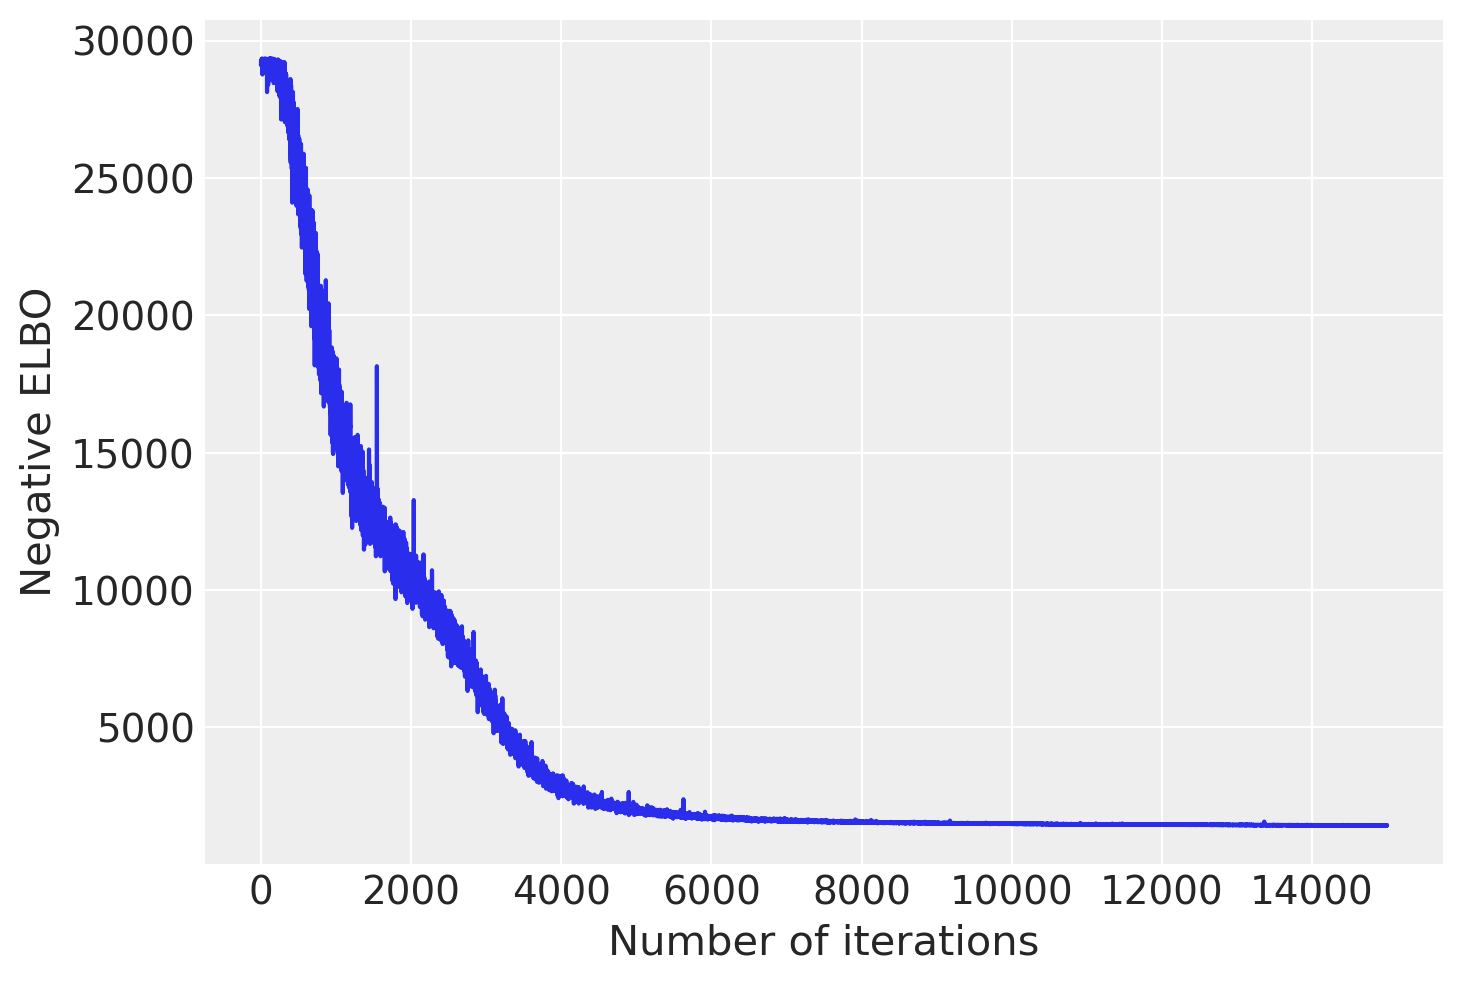

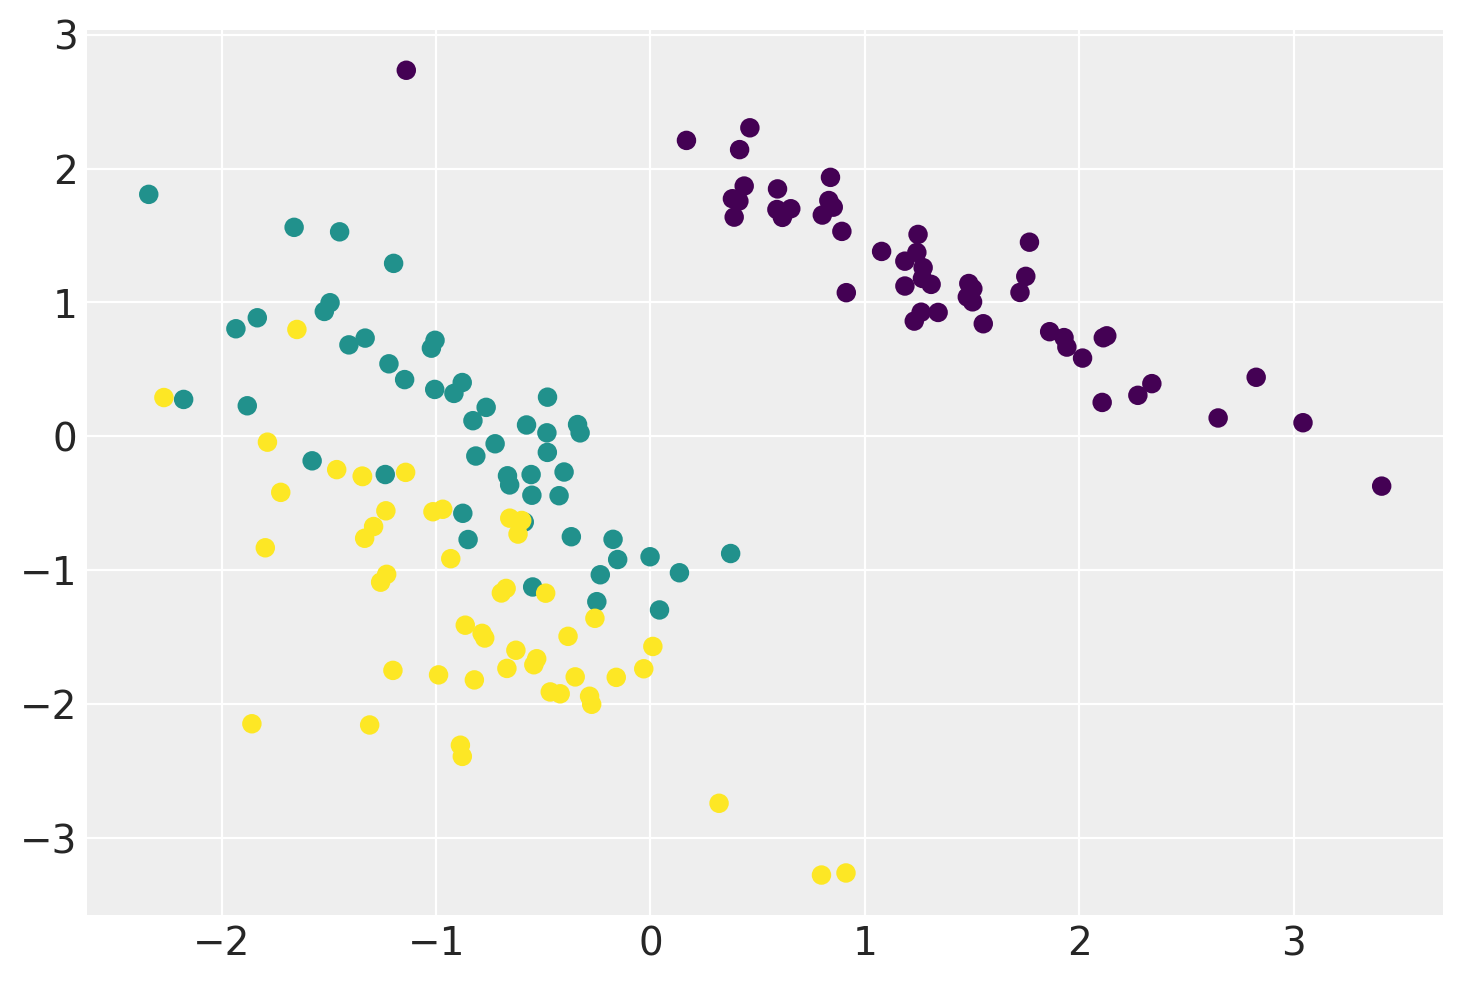

In [4]:
# Linear GP-LVM model
@pm.model
def GPLVM():
    # A normal prior over the projected data
    x = yield pm.MvNormalCholesky('x', loc=np.zeros(2), scale_tril=np.eye(2), batch_stack=N)

    # Prior over the argumemnts of the covariance function.
    args = yield pm.HalfCauchy('args', np.array(5.), batch_stack=3)
    cov_fn = pm.gp.cov.Linear(args[0], args[1], args[2])
    gp = pm.gp.MarginalGP(cov_fn=cov_fn)

    # We put a marginal likelihood over every feature in the dataset.
    for i in range(4):
        y = yield gp.marginal_likelihood(f'y{i}', X=x, y=Y[:, i], noise=np.array(0.01))

model = GPLVM()
advi = pm.fit(
    model,
    num_steps=15000
)

plt.plot(advi.losses)
plt.xlabel('Number of iterations')
plt.ylabel('Negative ELBO')
plt.show()

trace = advi[0].sample(15000)

xx = np.asarray(trace.posterior['GPLVM/x'])
xx = xx.squeeze()

plt.scatter(xx.mean(0)[:, 0], xx.mean(0)[:, 1], c=iris.target)
plt.show()

### GP-LVMs with a non-linear kernel

Below is the demonstration of a GP-LVM using a non-linear RBF kernel.

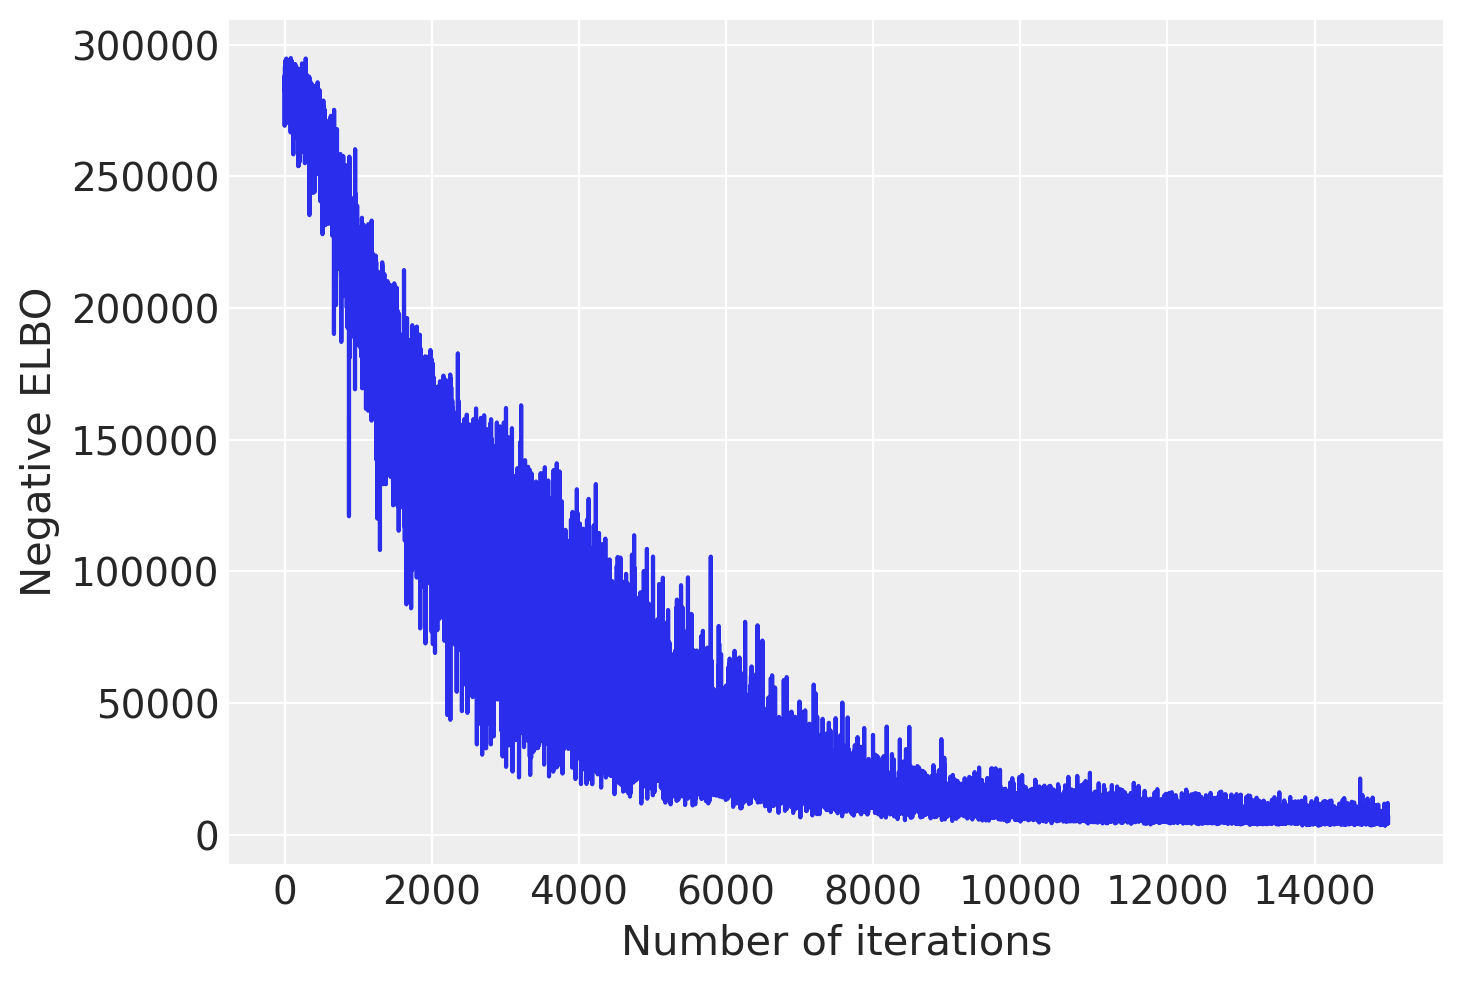

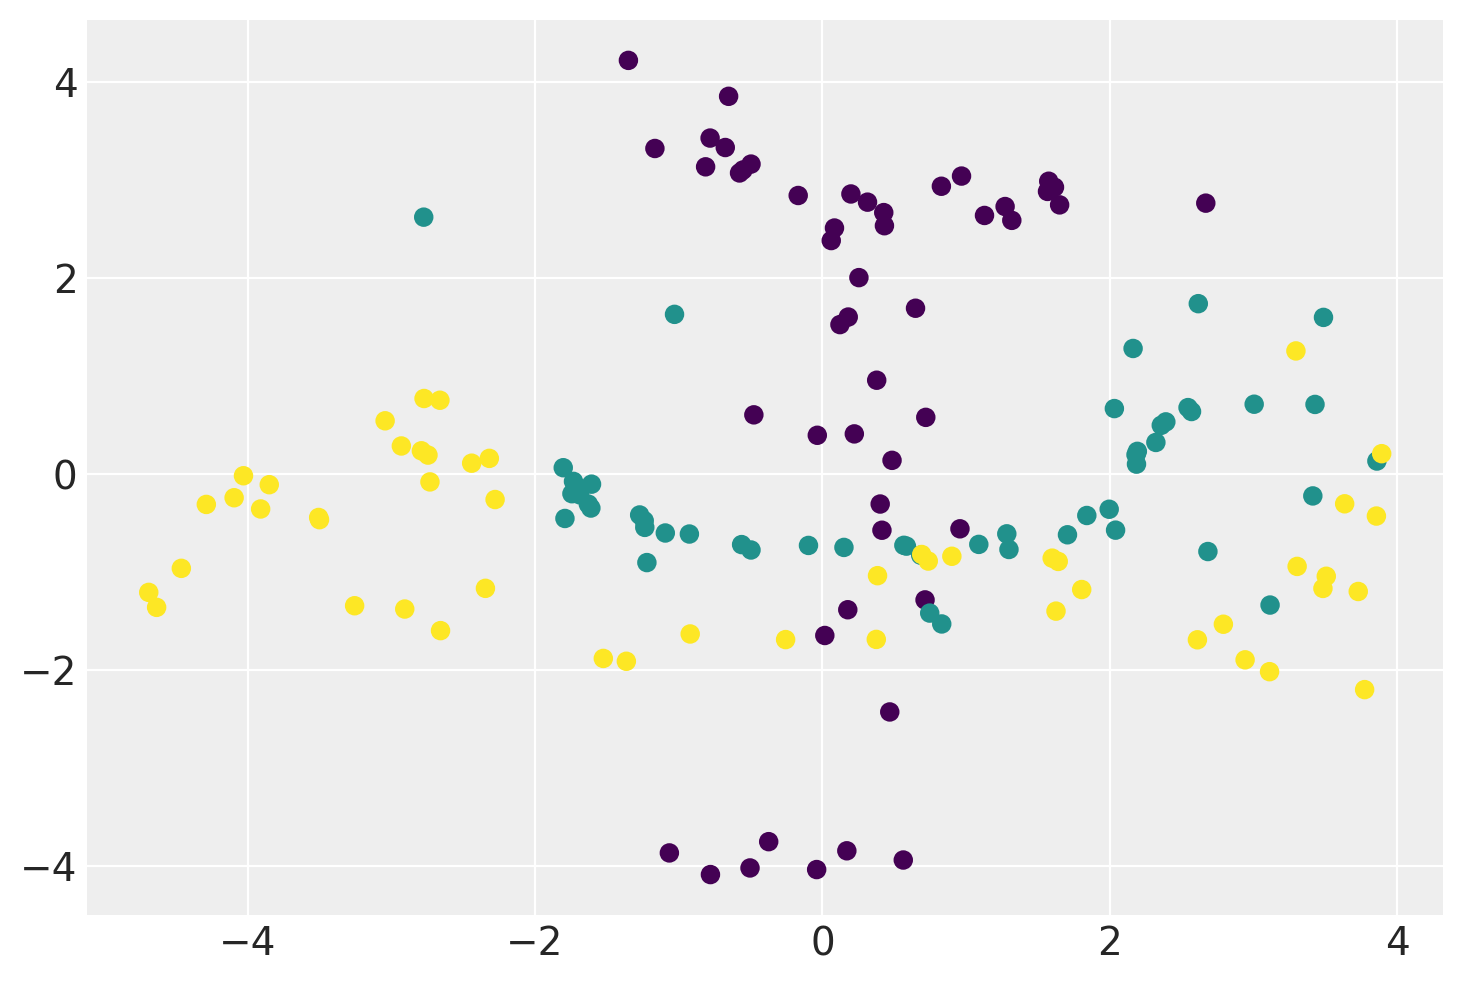

In [5]:
# Experiments with Non-Linear Kernels
@pm.model
def GPLVM():
    # A normal prior over the projected data
    x = yield pm.MvNormalCholesky('x', loc=np.zeros(2), scale_tril=np.eye(2), batch_stack=N)

    # Prior over the argumemnts of the covariance function.
    args = yield pm.Uniform('args', np.array(1.), np.array(100.0), batch_stack=2)
    cov_fn = pm.gp.cov.ExpQuad(args[0], args[1])
    gp = pm.gp.MarginalGP(cov_fn=cov_fn)

    # We put a marginal likelihood over every feature in the dataset.
    for i in range(P):
        y = yield gp.marginal_likelihood(f'y_{i}', X=x, y=Y[:, i], noise=np.array(1e-3))

model = GPLVM()
advi = pm.fit(model, num_steps=15000)

plt.plot(advi.losses)
plt.xlabel('Number of iterations')
plt.ylabel('Negative ELBO')
plt.show()

trace = advi[0].sample(15000)

xx = np.asarray(trace.posterior['GPLVM/x'])
xx = xx.squeeze()

plt.scatter(xx.mean(0)[:, 0], xx.mean(0)[:, 1], c=iris.target)
plt.show()

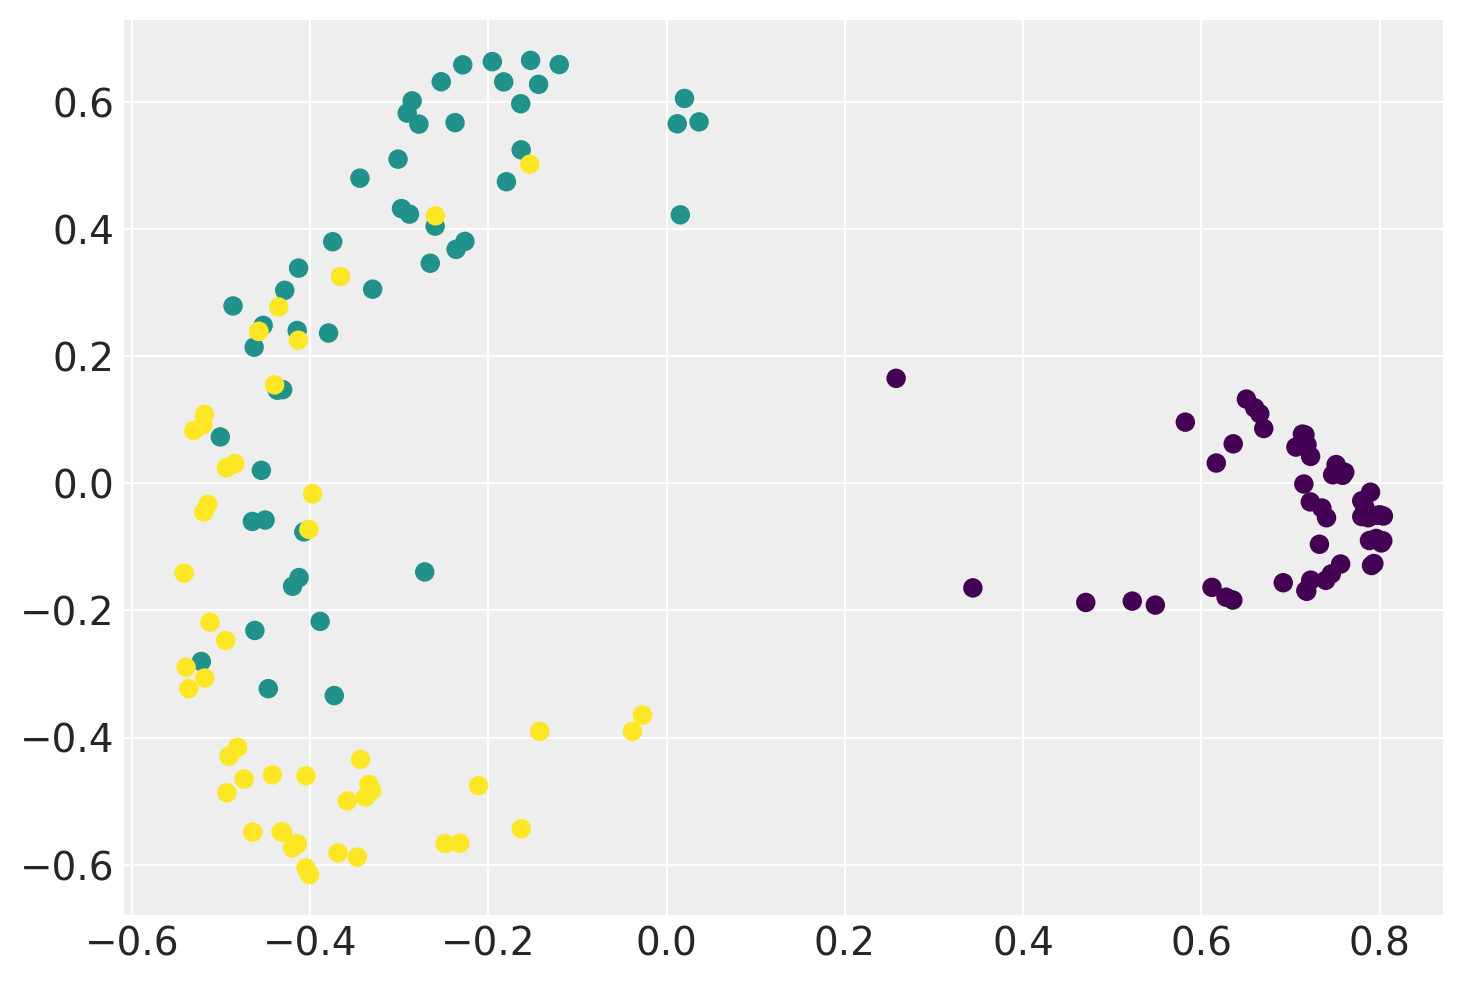

In [6]:
# Comparing with sklearn
transformer = KernelPCA(n_components=2, kernel='rbf')
xx = transformer.fit_transform(Y)

plt.scatter(xx[:, 0], xx[:, 1], c=iris.target)
plt.show()

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc4      4.0a2
arviz      0.9.0
tensorflow 2.4.0-dev20200705
numpy      1.19.0
last updated: Fri Aug 07 2020 

CPython 3.8.0
IPython 7.16.1
watermark 2.0.2
